<a href="https://colab.research.google.com/github/Johyeonje/Start_Tensorflow_2.0_Programming/blob/master/Start!_chap9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import Image
import tensorflow as tf
import numpy as np

#오토인코더

지금까지의 네트워크들은 입력과 출력의 쌍이 존재하는 관계의 학습을 지도학습이라고 한다.    
    
오토인코더(AutoEncoder)는 입력에 대한 출력을 학습해야 한다는 점은 다른 지도학습 네트워크와 동일하지만 그 출력이 입력과 동일하다는 점이 특이하다.    
즉 오토 인코더는 자기 자신을 재생성하는 네트워크이다.    
이미 입력 데이터를 가지고 있는데 왜 출력으로 자기 자신을 재생성하는 것일까?

##9.1 인코더와 디코더, 잠재변수

오토인코더는 크게 세 부분으로 나눌 수 있다. 가운데의 주황색 Dense 레이어로 표시되는 잠재 변수(Latent Vector)를 중심으로 입력에 가까운 부분을 인코더(Encoder), 출력에 가까운 부분을 디코더(Decoder)로 분류할 수 있다.

In [ ]:
Image('/content/drive/My Drive/DeepLearning/Start!_Tensorflow/images/encod_1.png', width='700')

`인코더`는 `입력에서 잠재 변수를 만드는 부분`이고 `디코더`는 `잠재 변수를 출력으로 만드는 부분`이다.    
인코더는 지금까지 컨볼루션 신경망에서 봐왔던 `특징 추출기와 같은 역할`을 한다. 특징 추출기는 입력 이미지에서 특징을 추출해서 일차원 벡터로 만들었다. 이 `일차원의 벡터가 바로 잠재 변수`이다. 잠재 변수에는 입력 데이터가 압축되어 있다. 이 `압축된 데이터를 다시 해석해서 출력 데이터, 즉 동일한 입력 데이터로 만들어 주는 것`이 `디코더의 역할`이다.    
오토인코더의 운영체제에서 자주 사용하는 파일 압축과도 비교할 수 있다. 보통은 zip같은 확장자를 사용하는 `압축 파일은 압축하기 전과 압축을 해제한 뒤의 내용이 동일`하다. 이것을 `비손실 압축이`라고 한다.    
이와 달리 `오토 인코더는 손실 압축으로 입력과 출력이 완전히 일치하지는 않다.` 그 대신 `압축률이 비손실 압축보다 크게 올라가며`, `압축률을 높이는 과정`에서 `잠재 변수에 원본 데이터의 특징을 잘 나타내는 효율적인 방법을 찾게 된다.` 더 적은 양의 데이터로 많은 양의 정보를 표현해야 하기 때문이다.

In [ ]:
Image('/content/drive/My Drive/DeepLearning/Start!_Tensorflow/images/encod_2.png', width='600')

압축된 잠재 변수는 데이터의 특징을 가장 잘 표현하는 정보이기 때문에 여러 가지 용도로 쓰인다. 오토인코더에서는 잠재 변수를 입력으로 삼아 디코더를 통해 이미지 등을 생성한다.   
최근 가장 주목받고 있는 적대적 생성모델(Generative Adversarial Netswork, GAN)의 생성자에서는 랜덤하게 생성된 변수를 잠재변수처럼 활용해서 새로운 이미지를 얻는다.

##9.2 MNIST 데이터세트에 적용하기

###MNIST 데이터세트 불러오기

In [3]:
(train_X, train_Y), (test_X, test_Y) = tf.keras.datasets.mnist.load_data()
print(train_X.shape, train_Y.shape)

train_X = train_X / 255.0
test_X = test_X / 255.0

(60000, 28, 28) (60000,)


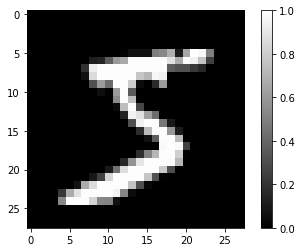

5


In [4]:
import matplotlib.pyplot as plt
plt.imshow(train_X[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

print(train_Y[0])

다음으로 가장 간단한 형태의 오토인코더를 만드렁보자.    
먼저 Dense 레이어를 사용한 모델을 학습시켜본 후에 컨볼루션 레이어를 사용해 보자

###Dense 오토인코더 모델 정의

In [5]:
train_X = train_X.reshape(-1, 28*28)
test_X = test_X.reshape(-1, 28*28)
print(train_X.shape, train_Y.shape)

model = tf.keras.Sequential([
        tf.keras.layers.Dense(784, activation='relu', input_shape=(784,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(784, activation='sigmoid')
])

model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
model.summary()

(60000, 784) (60000,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               50960     
Total params: 716,640
Trainable params: 716,640
Non-trainable params: 0
_________________________________________________________________


Flatten레이어를 사용하는 대신에 train_X와 test_X의 차원을 직접 reshape() 함수로 변환했다. 그 이유는 입력과 출력의 형태가 같아야 하기 때문이다.    
입력을 변환하지 않은 채로 앞에 Flatten 레이어를 넣어서 (28, 28) 차원의 입력을 넣으면 뒤에서도 출력의 차원을 다시 (28, 28)로 맞추기 위해 Reshape 레이어를 사용해야 할 것이다. 여기서는 그런 불편을 없애기 위해 데이터의 차원을 직접 변환한 다음에 사용해서 네트워크를 간결하게 만든다.    
네트워크의 첫 번째 Dense 레이어와 세 번째 Dense 레이어는 뉴런의 수가 같아서 대칭을 이룬다. 이 둘은 각각 인코더와 디코더의 역할을 한다.    
두 번째 레이어는 첫 번째와 세 번째보다 뉴런의 수가 꽤 적습니다. 오토인코더의 가운데에 있는 이 레이어가 잠재 변수를 만드는 레이어이고, 이 레이어의 출력이 입력의 잠재 변수가 된다.

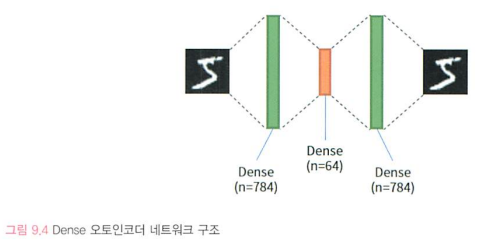

In [6]:
Image('/content/drive/My Drive/DeepLearning/Start!_Tensorflow/images/encod_3.png', width='600')

###모델 학습

In [7]:
model.fit(train_X, train_X, epochs=10, batch_size=256)

Epoch 1/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0497
Epoch 2/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0163
Epoch 3/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0114
Epoch 4/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0095
Epoch 5/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0084
Epoch 6/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0076
Epoch 7/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0071
Epoch 8/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0067
Epoch 9/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0064
Epoch 10/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0061


0.0066이라는 loss가 나왔는데 어느정도 재생성을 능력을 가졌는지 학습에 쓰이지 않은 데이터로 테스트 해보자.

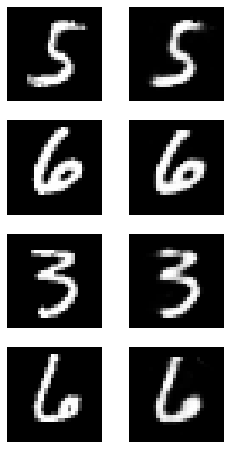

313/313 [==============================] - 0s 1ms/step - loss: 0.0059


0.005865398328751326

In [8]:
import random

plt.figure(figsize=(4,8))
for c in range(4):
  plt.subplot(4, 2, c*2+1)
  rand_index = random.randint(0, test_X.shape[0])
  plt.imshow(test_X[rand_index].reshape(28,28), cmap='gray')
  plt.axis('off')

  plt.subplot(4, 2, c*2+2)
  img = model.predict(np.expand_dims(test_X[rand_index], axis=0))
  plt.imshow(img.reshape(28, 28), cmap='gray')
  plt.axis('off')

plt.show()

model.evaluate(test_X, test_X)

평가 시에도 학습과 비슷한 성능이 나오는 것을 볼 수 있다. 실제 출력되는 이미지도 입력 이미지와 거의 흡사하지만 약간 흐릿한 정도이다.    
이번엔 컨볼루션 신경망을 사용해보자.

###컨볼루션 오토인코더 모델 정의

In [9]:
train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)

model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=(2,2), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=2, strides=(2,2), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(7*7*64, activation='relu'),
        tf.keras.layers.Reshape(target_shape=(7,7,64)),
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=(2,2), padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=2, strides=(2,2), padding='same', activation='sigmoid')
])

model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          8256      
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                200768    
_________________________________________________________________
dense_4 (Dense)              (None, 3136)              203840    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)       

컨볼루션 레이어를 사용하기 위해 데이터에 reshape() 함수를 사용해서 컬러 차원을 더해준다. 흑백 이미지이기 때문에 마지막 차원의 수는 1이 된다.    
그 다음에는 지금까지 계속 다뤄온 컨볼루션 레이어인 Conv2D 레이어를 2개 쌓는다.    
그런데 여기에는 컨볼루션 레이어와 함께 쓰이는 풀링레이어가 없는 대신 kernel_sie=2, strides=(2,2)로 설정해서 풀링과 같은 효과를 낸다.

####? 왜 풀링이랑 이거랑 뭐가다름?

그 다음에는 잠재 변수를 만들기 위해 Dense 오토인코더와 동일한 크기로 64개의 뉴런을 가지는 Dense 레이어를 배치한다. 그 전에 3차원 데이터를 1차원으로 바꿔주기 위해 Flatten 레이어를 통과한다.


잠재변수를 만들었으니 디코더를 만든다. 디코더는 인코더와 대칭이 되도록 쌓는다.    
잠재 변수 레이어와 연결된 레이어는 (7, 7, 64)크기의 Conv2D 레이어 였으므로 그 레이어와 뉴런 수를 동일하게 만들기 위해 먼저 Dense 레이어의 뉴런 수를 7x7x64로 넣는다.

####Conv2DTranspose

마지막에 이어지는 2개의 레이어는 이름처럼 Conv2D레이어가 하는 일의 반대되는 계산, 즉 입력이 하나의 값을 컨볼루션에 통과시켜서 출력의 여러 값을 계산해주는 레이어이다. (=디컨볼루션 레이어)    
두번째 Conv2DTranspose 레이어는 필터 개수가 1개로 흑백 출력 이미지의 채널 수와 일치한다. 이때 sigmoid 활성화함수를 사용해 0에서 1사이의 출력 값이 나오게 한다.

###컨볼루션 오토인코더 모델 학습

In [10]:
model.fit(train_X, train_X, epochs=20, batch_size=256)

Epoch 1/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0816
Epoch 2/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0304
Epoch 3/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0226
Epoch 4/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0202
Epoch 5/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0191
Epoch 6/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0185
Epoch 7/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0181
Epoch 8/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0178
Epoch 9/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0176
Epoch 10/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0174
Epoch 11/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0173
Epoch 12/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0172
Epoch 13/20
235/235 [====

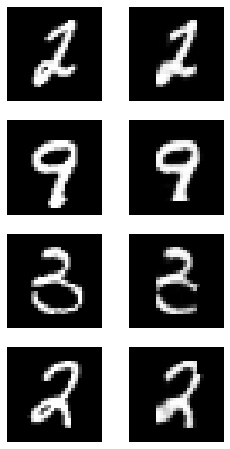

313/313 [==============================] - 1s 2ms/step - loss: 0.0163


0.016302669420838356

In [11]:
import random

plt.figure(figsize=(4,8))
for c in range(4):
  plt.subplot(4, 2, c*2+1)
  rand_index = random.randint(0, test_X.shape[0])
  plt.imshow(test_X[rand_index].reshape(28,28), cmap='gray')
  plt.axis('off')

  plt.subplot(4, 2, c*2+2)
  img = model.predict(np.expand_dims(test_X[rand_index], axis=0))
  plt.imshow(img.reshape(28, 28), cmap='gray')
  plt.axis('off')

plt.show()

model.evaluate(test_X, test_X)

Dense에 비해 두배의 epoch를 훈련시켰지만 loss는 오히려 높고 결과 이미지 역시 중간중간 각진 부분이 보인다. 이는 네트워크의 일부분에서 값이 아예 사라지는 것을 의미한다. 마지막 레이어를 제외하면 활성화함수로 relu를 사용했는데 relu는 양수는 그대로 반환하지만 0이나 음수는 0으로 반환한다. 때문에 뉴런의 계산값 중 음수가 되는 결과가 많을 경우 그 뉴런의 출력은 무조건 0이 된다.    
출력이 0이 되면 다음 레이어의 가중치에 곱해지기 때문에 가중치의 효과를 모두 0으로 만들어 버리고 편향이 더해지더라도 편향이 0이나 음수라면 다시 relu를 통과한 후에 0이 되고만다.

In [ ]:
Image('/content/drive/My Drive/DeepLearning/Start!_Tensorflow/images/encod_4.png', width='600')

위 그림처럼 편향이 모두 음수라고 가정하면 출력값 0은 뒤쪽에 레이어에 16배까지 영향을 준다. 이러한 특성 때문에 이전 출력에서 각진 모습이 나오게 된것이다.   
이 문제를 해결하기 위해서 ReLU의와 비슷하지만 음수로 받았을 때 0보다 조금 작은 음수를 출력하는 여러 종류의 함수를 고안했다 그중 elu(Exponential Linear Unit)는 다음과 같은 식으로 계산된다.


$elu(x)=\alpha(e^x-1),x < 0$     
$elu(x)=x, x>=0$

In [ ]:
Image('/content/drive/My Drive/DeepLearning/Start!_Tensorflow/images/encod_5.png', width='400')

여기서 알파는 tf.keras에서는 기본값으로 1.0을 쓴다. 알파($\alpha$)가 1.0일 때 ReLU와 elu의 값을 비교해보면 elu는 0 이하에서 부드럽게 감소하며 -1에 수렵하게 된다. 이렇게 약간의 값이 남아있는 것이 오토 인코더 학습에 미치는 영향을 보자.

###활성화함수를 elu로 모델 변경 후 학습

In [12]:
train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)

model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=(2,2), activation='elu', input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=2, strides=(2,2), activation='elu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='elu'),
        tf.keras.layers.Dense(7*7*64, activation='elu'),
        tf.keras.layers.Reshape(target_shape=(7,7,64)),
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=(2,2), padding='same', activation='elu'),
        tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=2, strides=(2,2), padding='same', activation='sigmoid')
])

model.compile(optimizer=tf.optimizers.Adam(), loss='mse')

model.fit(train_X, train_X, epochs=20, batch_size=256)

Epoch 1/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0567
Epoch 2/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0185
Epoch 3/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0131
Epoch 4/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0114
Epoch 5/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0106
Epoch 6/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0099
Epoch 7/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0094
Epoch 8/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0089
Epoch 9/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0084
Epoch 10/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0082
Epoch 11/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0078
Epoch 12/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0073
Epoch 13/20
235/235 [====

3배 가까이 낮아진 loss 값을 확인할 수 있다.

###결과확인

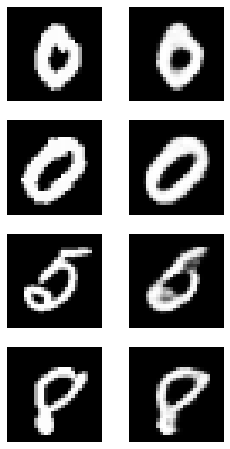

313/313 [==============================] - 1s 2ms/step - loss: 0.0059


0.005879623349756002

In [13]:
import random

plt.figure(figsize=(4,8))
for c in range(4):
  plt.subplot(4, 2, c*2+1)
  rand_index = random.randint(0, test_X.shape[0])
  plt.imshow(test_X[rand_index].reshape(28,28), cmap='gray')
  plt.axis('off')

  plt.subplot(4, 2, c*2+2)
  img = model.predict(np.expand_dims(test_X[rand_index], axis=0))
  plt.imshow(img.reshape(28, 28), cmap='gray')
  plt.axis('off')

plt.show()

model.evaluate(test_X, test_X)

이처럼 `활성화함수를 비롯한 하이퍼파라미터의 선택이 매우 중요함`을 확인할 수 있었다.

##9.3 클러스터링

잠재변수의 데이터를 효과적으로 복원할 수 있는 중요 정보만을 포함하는 특징을 이용해 여러개의 군집으로 클러스터링(Clustering)할 수 있다.    
클러스터링은 원래 비지도학습(Unsupervised Learning)의 한 종류이다. 지도학습과는 달리 비지도학습은 입력에 대한 정답 출력이 존재하지 않는다. `쉽게 답을 내리기 어려운 문제들에 대해 클러스터링 알고리즘을 사용하면 군집으로 나누는 시도를 해볼 수 있다.` 그리고 학습 결과를 시각화하거나 수식에 넣어서 학습이 잘 됐는지 판단할 수 있다.

###K-평균 클러스터링(K-Means Clustering)

: 주어진 입력 중 K개의 클러스터 중심을 임의로 정한 다음에 각 데이터와 K개의 중심과의 거리를 비교해서 가장 가까운 클러스터로 배당하고, K개의 중심의 위치를 해당 클러스터로 옮긴 후, 이를 반복하는 간단한 알고리즘이다.

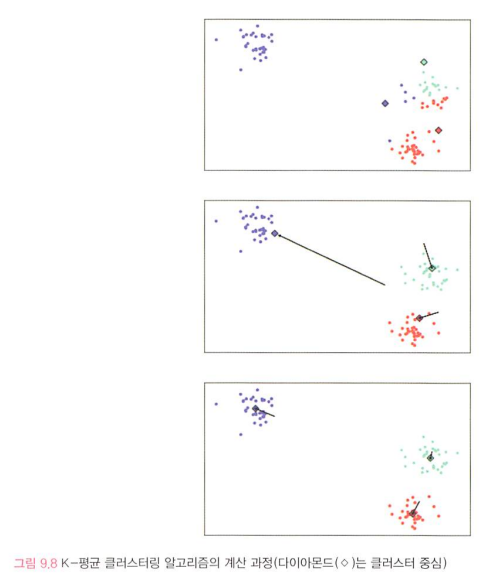

In [14]:
Image('/content/drive/My Drive/DeepLearning/Start!_Tensorflow/images/kclustering_1.png', width='400')

위 이미지는 2차원 데이터에서 K-평균 클러스터링 알고림을 계산한다. 다이아몬드 표시된 클러스터의 줌심은 알고리즘 계산 과정에서 군집의 중심으로 이동한다.    
3차원 이상의 다차원 데이터에서도 K-평균 클러스터링을 적용해볼 수 있다.

먼저 잠재변수를 분리할 수 있는 모델을 만든다. 함수형 API를 이용해 앞선 예제에서의 가중치를 재사용해본다. 입력은 model의 입력을 그대로 사용, 출력은 4번째 레이어의 Dense 레이어의 출력을 사용한다.

In [15]:
latent_vector_model = tf.keras.Model(inputs=model.input, outputs=model.layers[3].output)
latent_vector = latent_vector_model.predict(train_X)
print(latent_vector.shape)
print(latent_vector[0])

(60000, 64)
[-0.35441828 -1.         -1.         -0.9999998   0.68166023 30.523937
 -0.99999994 23.287071   -0.99999994 21.318316   39.25898    -1.
 16.865595   17.228067   21.105898   29.149761   -0.9999992  -1.
 -0.83235735 -0.99999994  3.8521473  -1.          4.466769   23.093752
 -0.99990875 23.284302    4.3694873  -0.99999994 28.85165    -1.
 -0.99999964 22.498549   -0.99997646 -1.         -1.         -0.9999997
 -0.9999998  -0.9999996  -1.         18.492525   -0.99999535 26.719357
  8.786126   -1.         39.54299    23.90261    -1.         -0.99999964
 -0.99999976 -0.99999994  0.3222592   3.8482862  -0.9999999   6.7015
 -1.         -0.9999864  20.31177    15.715071   23.63492    13.732007
 11.296425    7.4455767  15.653898   -0.99999833]


한줄로 모델을 만들고 훈련 데이터를 64차원의 잠재변수로 만들었다. 이제 이 잠재변수에 K-평균 클러스터링 알고리즘을 사용해 클러스터링을 시도한다.    
이때 편리하게 K-평균 클러스터링 알고리즘을 불러올 수 있는 `사이킷런(scikit-learn)` 라이브러리를 사용할 수 있다.    
사이킷 런은 데이터 마이닝과 분석을 위한 머신러닝 라이브러리로서 엄청나게 많은 기능을 제공하기 때문에 머신러닝의 공부에 필수 라이브러리이다.

In [16]:
%%time
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
kmeans.fit(latent_vector)

CPU times: user 16.5 s, sys: 3.16 s, total: 19.7 s
Wall time: 16.2 s


%%time : 셀의 수행시간을 측정    
Wall time : 실제 걸린 시간    
sklearn : 사이킷런을 불러옴

```python
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
```
KMeans() 함수로 K-평균 클러스터링 알고리즘을 계산할 객체를 초기화한다.   
`n_cluster`는 K에 해당하는 중심의 개수이다. 여기서는 MNIST의 라벨 수와 같은 10을 선택한다.    
`n_init`는 알고리즘의 실행 횟수로, 여기서 10을 입력했기 때문에 중심의 위치를 다르게 선택해서 10번 테스트한 뒤 가장 좋은 결과를 저장한다.    
`random_state`는 알고리즘의 계산 결과를 동일하게 가져가기 위해 지정하는 랜덤 초기화 숫자이다.    
tf.keras 처럼 fit() 함수를 사용해 앞에서 계산한 잠재변수로 알고리즘을 학습시킨다. 이밖에도 predict() 함수 등 두 문법은 꽤 비슷한 점이 있다.

####계산결과 확인

In [17]:
print(kmeans.labels_)
print(kmeans.cluster_centers_.shape)
print(kmeans.cluster_centers_[0])

[8 4 5 ... 8 0 8]
(10, 64)
[-0.41875818 -0.9999998  -0.99999976 -0.9999986  18.477762   14.653063
 -0.9999678  11.829773   -0.99999917 17.062778   24.62798    -0.9999994
 13.615514   16.643515   23.690454   14.295796   -0.99993366 -0.99999946
  3.0940723  -0.99999934  5.0250316  -0.9999994   6.4299893  18.974098
 -0.9985285  27.910284   25.90731    -0.9999977  20.89958    -0.99999917
 -0.99999803 20.753231   -0.9995949  -0.9999994  -0.999999   -0.9999908
 -0.99992037 -0.9999988  -0.9999969  14.627548   -0.9998583  35.774708
  5.3713455  -0.9999997  11.149454   12.551305   -0.99999976 -0.9999945
 -0.9999974  -0.99999934  8.012179    6.0921283  -0.99999774 15.086287
 -0.9999998  -0.99943596 21.591      13.540255   12.027451   28.22462
 20.53202    21.627663   10.249201   -0.99888515]


labels_에는 각 데이터가 0부터 9사이의 어떤 클러스터에 속하는지 정보가 저장된다. cluster_centers_에는 각 클러스터의 중심 좌표가 저장되지만 64차원이라 확인하기 힘들다. 출력해보자.

####클러스터링 결과 출력

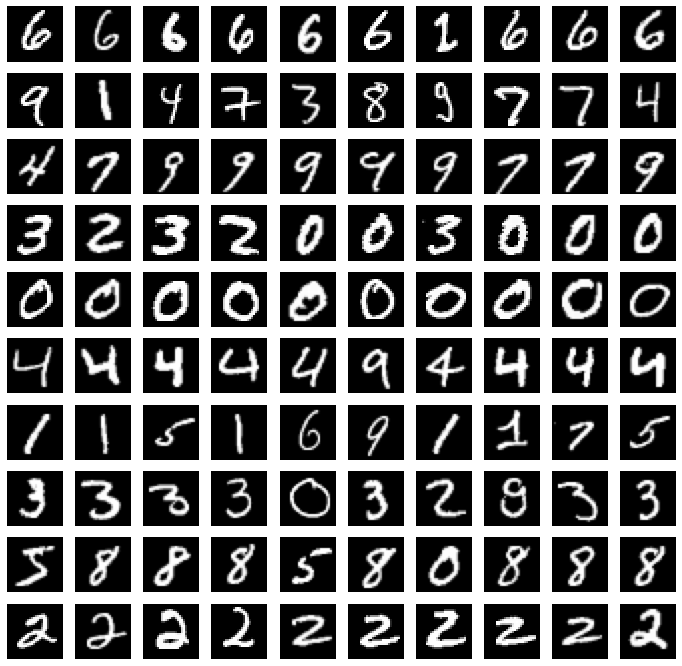

In [18]:
plt.figure(figsize=(12,12))

for i in range(10):
  images = train_X[kmeans.labels_ == i]
  for c in range(10):
    plt.subplot(10, 10, i*10+c+1)
    plt.imshow(images[c].reshape(28,28), cmap='gray')
    plt.axis('off')

plt.show()

0이나 6번처럼 잘된 클러스터도 보이지만 그렇지 않은 결과도 있다. 숫자가 다르면서 같은 클러스터로 분류된 이미지들은 선의 굵기가 비슷하게 보이기도 한다.(1,5,7)    
잠재변수의 차원 수를 늘리거나 KMeans()의 n_init를 늘려서 좀 더 분류가 잘 되도록 시도해볼 수 있다.    
또는 n_cluster를 늘려서 클러스터를 더욱 세분화할 수 있다. 얇게 써진 0, 두껍게 써진 2와 같은 식으로 분류하는 것이다.

하지만 시각화 문제는 남는다. 클러스터링 결과를 시각화하려면 결국 2차원 혹은 3차원으로 잠재변수가 가진 차원을 축소해야한다. t-SNE는 바로 이런 문제를 해결하는 알고리즘이다.

###t-SNE

: 강력한 시각화 도구로 고차원의 데이터를 저차원(주로 2차원 혹은 3차원)의 시각화를 위한 데이터로 변환한다.    
`K-평균 클러스터링이 클러스터를 계산하기 위한 단위로 중심과 각 데이터의 거리를 계산`하는 데 비해,    
`t-SNE는 각 데이터의 유사도를 정의하고, 원래 공간에서의 유사도와 저차원 공간에서의 유사도가 비슷해지도록 학습`시킨다.    
    
SNE는 Stochastic Neighbor Embedding의 약자로, 여기서 유사도는 확률로 표현되기 때문에 확률적(Stochastic)이라는 단어가 포함되는 것이다.    
t는 t-분포를 나타낸다. t-분포는 정규분포와 비슷하게 생겼지만 중심이 좀더 낮고 꼬리가 좀 더 두꺼운 분포이다.

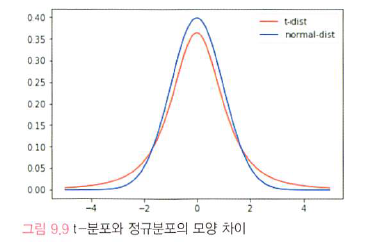

In [19]:
Image('/content/drive/My Drive/DeepLearning/Start!_Tensorflow/images/t-sne.png', width='400')

거리를 확률로 표현한다는 것은 데이터 하나를 중심으로 다른 데이터를 거리에 대한 t- 분포의 확률로 치환시키는 것이다. 아래 그림처럼 가까운 거리의 데이터는 확률값이 높아지고 먼거리는 확률이 낮아진다.

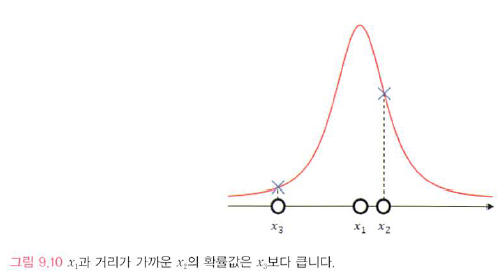

In [20]:
Image('/content/drive/My Drive/DeepLearning/Start!_Tensorflow/images/t-sne2.png', width='400')

고차원과 저차원에서 확률값을 각각 구한 다음, `저차원의 확률값이 고차원에 가까워지도록 학습시키는 것`이 t-SNE 알고리즘의 주요 내용이다. t-SNE는 알고리즘 가운데 계산 속도가 느린 편에 속하기 때문에 사이킷런의 함수 설명에서는 고차원의 데이터라도 먼저 차원 축소를 진행해서 50차원 정도의 데이터를 넣을 것을 권장한다.    
잠재변수가 64차원이기 때문에 t-SNE에 사용하기 적절하다. 다만 데이터가 많아지면 계산속도가 느려지기 때문에 훈련 데이터 중 앞에서 5000개만 사용하자.

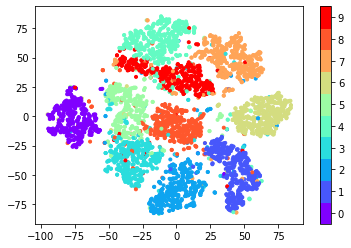

CPU times: user 1min, sys: 0 ns, total: 1min
Wall time: 32.7 s


In [21]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate=100, perplexity=15, random_state=0)
tsne_vector = tsne.fit_transform(latent_vector[:5000])

cmap = plt.get_cmap('rainbow', 10)
fig = plt.scatter(tsne_vector[:,0], tsne_vector[:,1], marker='.', c=train_Y[:5000], cmap=cmap)
cb = plt.colorbar(fig, ticks=range(10))
n_clusters = 10
tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
cb.set_ticks(tick_locs)
cb.set_ticklabels(range(10))

plt.show()

t-SNE는 TSNE라는 이름으로 불러올 수 있다. `Manifold`는 다양체라는 뜻으로 도넛같이 부분적으로 유클리드 공간과 닮은 위상 공간을 말한다. `쉽게 말해 2차원은 평면, 3차원은 부피를 갖는 사물의 형태`이다. sklearn.manifold에는 고차원의 공간에 분포하는 데이터를 이러한 쉽게 볼 수 있는 사물 형태로 분포되도록 학습시키는 `다양체 학습(manifold learning)을 위한 여러 알고리즘`이 있다. t-SNE는 그중 하나이다.

```python
tsne = TSNE(n_components=2, learning_rate=100, perplexity=15, random_state=0)
```
`n_components` : 저차원 수를 의미 (=2차원)    
`learning_rate` : 학습률로 10에서 1000사이의 큰 숫자를 넣는다.    
`perplexity` :  알고리즘 계산에서 고려한 최근접 이웃의 숫자이다. 보통 5에서 50사이의 숫자를 넣는다.    
`random_state` : KMeans와 마찬가지로 랜덤 초기화 숫자이다.

```python
tsne_vector = tsne.fit_transform(latent_vector[:5000])
```
TSNE는 `학습과 변환 과정을 동시에 진행하는 fit_transform() 함수로 결괏값을 반환`한다. 여기서는 앞서 말한대로 속도를 위해 훈련데이터 중 5000개만 사용한다.

출력 데이터를 보면 이미지 라벨에 따라 같은 숫자끼리 잘 뭉쳐있다.    
`t-SNE가 K-평균 클러스터링 알고리즘과 차별되는 점`은 `클러스터의 숫자인 K를 지정할 필요가 없다`는 것이다. 대신에 최근접 이웃의 숫자인 perplexity를 조절하며 알맞은 값을 찾을 수 있다.    
perplexity가 바뀜에 따라 어떻게 클러스터의 형태가 달라지는지 보자.

####다양한 perplexity 인수에 대한 t-SNE 결과

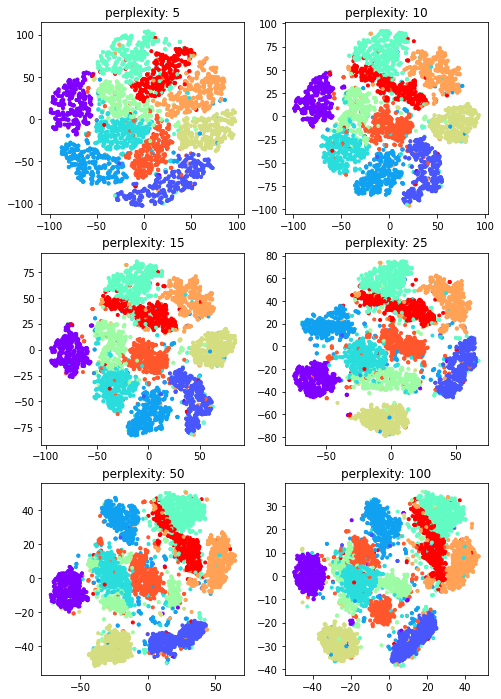

CPU times: user 7min 27s, sys: 869 ms, total: 7min 28s
Wall time: 3min 57s


In [24]:
%%time

perplexities = [5,10,15,25,50,100]
plt.figure(figsize=(8,12))

for c in range(6):
  tsne = TSNE(n_components=2, learning_rate=100, perplexity=perplexities[c], random_state=0)
  tsne_vector = tsne.fit_transform(latent_vector[:5000])

  plt.subplot(3, 2, c+1)
  plt.scatter(tsne_vector[:,0], tsne_vector[:,1], marker='.', c=train_Y[:5000], cmap='rainbow')
  plt.title('perplexity: {0}'.format(perplexities[c]))

plt.show()

perplexity가 높아질수록 뭉치는 클러스터도 있지만 뒤섞이는 클러스터도 보이는 것으로 볼 때 최적의 값을 찾기 위해서는 다른 하이퍼파라미터처럼 여러번의 실험이 필요할 것 같다.

클러스터 분리 결과를 좀 더 직관적으로 확인하기 위해 t-SNE로 분리된 클러스터 위에 MNIST 이미지를 표시해 보자.

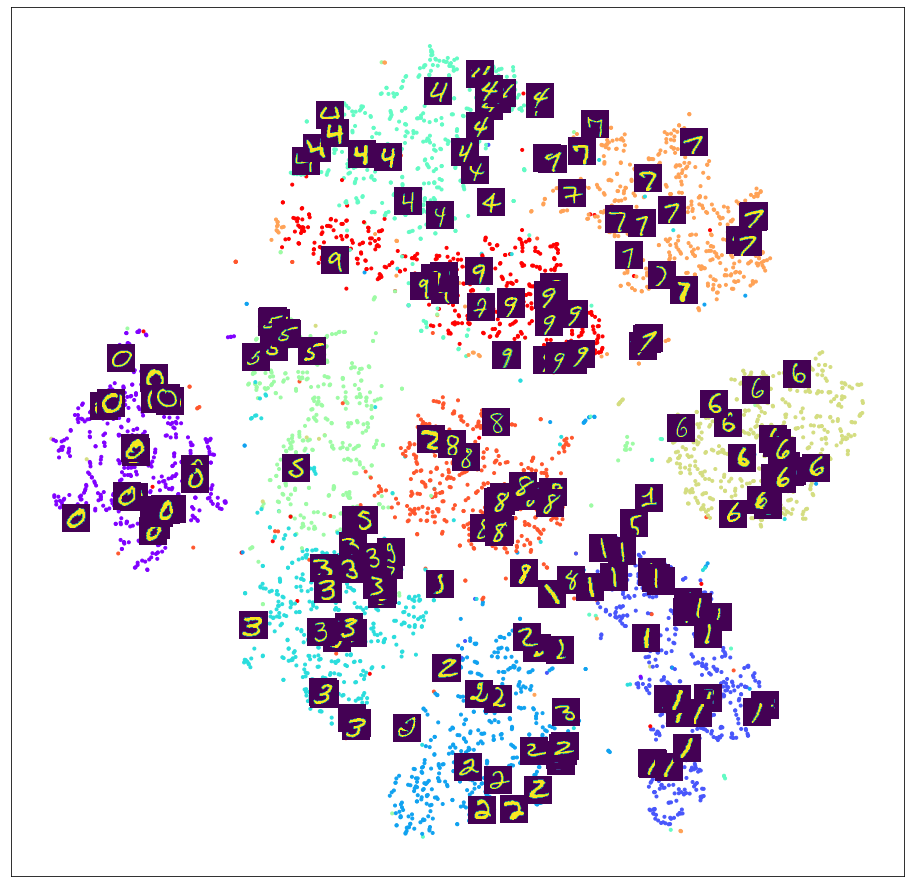

In [23]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

plt.figure(figsize=(16,16))

tsne = TSNE(n_components=2, learning_rate=100, perplexity=15, random_state=0)
tsne_vector = tsne.fit_transform(latent_vector[:5000])

ax = plt.subplot(1,1,1)
ax.scatter(tsne_vector[:,0], tsne_vector[:,1], marker='.', c=train_Y[:5000], cmap='rainbow')
for i in range(200):
  imagebox = OffsetImage(train_X[i].reshape(28,28))
  ab = AnnotationBbox(imagebox, (tsne_vector[i,0], tsne_vector[i,1]), frameon=False, pad=0.0)
  ax.add_artist(ab)

ax.set_xticks([])
ax.set_yticks([])
plt.show()

AnnotationBbox : 이미지나 텍스트 등의 주석을 그래프 위에 표시하기 위한 주석 상자는 그리는 함수이다.    
대부분의 출력 이미지들이 자신이 속한 클러스터에 표시되고 있다.

이렇게 t-SNE 시각화 위에 데이터를 표시하면 오토인코더로 추출된 잠재변수가 데이터를 효율적으로 압축하고 있음을 알 수 있다.

##9.4 초해상도 이미지 얻기

고해상도의 이미지를 저해상도로 변환하는 것은 쉽지만 반대 작업은 어려운 연산이다. 픽셀은 디지털 이미지의 최소단위이다.    
`초해상도(Super Resolution) 작업` : `픽셀로 구성된 이미지는 고해상도로 변환하면 이미지에서 사각형이 두드러져 보이는, 소위 픽셀이 깨지는 현상이 일어나는데, 이를 자연스러운 고해상도 이미지로 만들어주는 것`

이번 장에서 배운 오토인코더를 활용해서 초해상도 작업을 하는 네트워크를 학습시킬 수 있다. 오토인코더에서 파새오딘 수많은 네트워크 중 REDNet이라는 네트워크를 사용해 보자.    
REDNet은 Residual Encoder-Decoder Network의 약자로, 인코더와 디코더는 오토인코더에서 다루었고, Residual은 ResNet 등에서 사용하는 건너뛴 연결(skip-connection)이다. 우리말로 잔류 레이어라 부른다. 다수의 레이어가 중첩되는 구조에서 앞쪽의 정보를 잃어버리지 않기 위해 뒤쪽에 정보를 그대로 전달해 줄 때 건너뛴 연결이 사용된다.

REDNet에는 REDNet-10, REDNet-20, REDNet-30이 있는데 뒤의 숫자는 컨볼루션 레이어와 디컨볼루션 레이어를 합친 수이다. REDNet-30은 15개의 컨볼루션 레이어와 15개의 디컨볼루션 레이어로 구성된다. `입,출력과 그 사이의 모든 컨볼루션, 디컨볼루션 레이어를 거치는 데이터의 크기는 모두 동일하다.` 레이어를 많이 사용하기 때문에 앞쪽의 정보를 잃어버리지 않기 위해 2개의 컨볼루션 혹은 디컨볼루션을 거칠 때마다 건너뛴 연결을 사용한다. 건너뛴 연결을 합연산을 사용하며, tf.keras에서 Add 레이어를 사용하면 된다.

논문에서 사용한 이미지는 BSD(Berkeley Segmentation Dataset) 데이터세트이다. 이 데이터세트를 이용해 구현해 보자.

####BSD500 데이터세트 불러오기

In [25]:
tf.keras.utils.get_file('/content/bsd_images.zip', 'http://bit.ly/35pHZlC', extract=True)

!unzip /content/bsd_images.zip

37527552/37520292 [==============================] - 0s 0us/step
Archive:  /content/bsd_images.zip
   creating: images/
   creating: images/test/
  inflating: images/test/100007.jpg  
  inflating: images/test/100039.jpg  
  inflating: images/test/100099.jpg  
  inflating: images/test/10081.jpg   
  inflating: images/test/101027.jpg  
  inflating: images/test/101084.jpg  
  inflating: images/test/102062.jpg  
  inflating: images/test/103006.jpg  
  inflating: images/test/103029.jpg  
  inflating: images/test/103078.jpg  
  inflating: images/test/104010.jpg  
  inflating: images/test/104055.jpg  
  inflating: images/test/105027.jpg  
  inflating: images/test/106005.jpg  
  inflating: images/test/106047.jpg  
  inflating: images/test/107014.jpg  
  inflating: images/test/107045.jpg  
  inflating: images/test/107072.jpg  
  inflating: images/test/108004.jpg  
  inflating: images/test/108036.jpg  
  inflating: images/test/108069.jpg  
  inflating: images/test/109055.jpg  
  inflating: image

####pathlib을 사용해 모든 이미지 경로 불러오기

In [30]:
import pathlib
image_root = pathlib.Path('/content/images')

all_image_paths = list(image_root.glob('*/*'))
print(all_image_paths[:10])

[PosixPath('/content/images/train/65019.jpg'), PosixPath('/content/images/train/216053.jpg'), PosixPath('/content/images/train/159091.jpg'), PosixPath('/content/images/train/108073.jpg'), PosixPath('/content/images/train/209070.jpg'), PosixPath('/content/images/train/370036.jpg'), PosixPath('/content/images/train/140075.jpg'), PosixPath('/content/images/train/42044.jpg'), PosixPath('/content/images/train/80099.jpg'), PosixPath('/content/images/train/159045.jpg')]


! glob('* */* *') 같은 방식으로 한번에 싹다 불러올수있다!

각 파일 경로는 PosisPath라는 객체가 되는데, 이 객체에서 경로를 가져오기 위해서는 문자열로 반환하는 str()함수를 사용하면 된다.

####이미지 확인

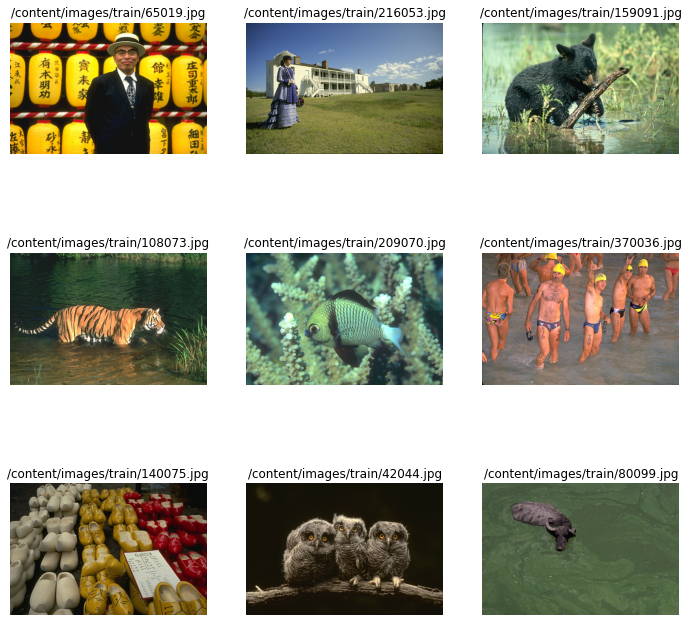

In [31]:
import PIL.Image as Image
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for c in range(9):
  plt.subplot(3,3,c+1)
  plt.imshow(plt.imread(all_image_paths[c]))
  plt.title(all_image_paths[c])
  plt.axis('off')
plt.show()

이 데이터셋은 이미지의 경계선 추출을 목적으로 만들어졌기 때문에 내용에 통일성이 없고 사이즈도 다른 오로지 외곽선을 얻기 위한 목적의 이미지로 구성돼 있다.    
BSD500은 200장의 훈련 데이터, 100장의 검증 데이터, 200장의 테스터 데이터로 구성되어 있으며, 각 데이터 세트 집합을 처리하기 위한 tf.data.Dataset을 각 데이터 세트마다 만들어보자. 그러기 위해서 이미지의 경로를 분리해서 저장한다.

In [32]:
train_path, valid_path, test_path = [], [], []

for image_path in all_image_paths:
  if str(image_path).split('.')[-1] != 'jpg':
    continue
  
  if str(image_path).split('/')[-2] == 'train':
    train_path.append(str(image_path))
  elif str(image_path).split('/')[-2] == 'val':
    valid_path.append(str(image_path))
  else:
    test_path.append(str(image_path))

tf.data.Dataset을 정의하기 전에 여기서 사용할 함수를 만든다. 지금의 이미지는 고해상도이기 때문에 이미지의 해상도를 일부러 낮추고 원본과 함께 반환하는 함수를 만들자. 또 학습 효율을 높이기 위해 이미지를 받아온 다음 이미지에서 가로x세로 50픽셀의 작은 조각(patch)을 잘라서 학습에 사용한다.

In [33]:
Image('/content/drive/My Drive/DeepLearning/Start!_Tensorflow/images/rednet_1.png', width='600')

TypeError: ignored

`저해상도 이미지는 입력`에 사용되고, `고해상도 이미지는 출력`에 사용된다. 이전 절에서 사용했던 오토인코더와 달리 이번에 사용되는 입력과 출력은 완전히 같지는 않지만 거의 비슷하기 때문에 오토인코더가 잘 학습되듯이 이렇게 초해상도 이미지를 얻는 네트워크도 잘 학습된다.

####원본에서 조각 추출 후 입력, 출력 데이터 반환 함수 정의

In [34]:
def get_hr_and_lr(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  hr = tf.image.random_crop(img, [50, 50, 3])
  lr = tf.image.resize(hr, [25,25])
  lr = tf.image.resize(lr, [50, 50])
  return lr, hr

JPEG 이미지는 tf.io.read_file()로 불러올 수 있다. 이미지를 불러온 후 decode_jpeg()함수를 사용해서 프로그램이 이해할 수 있는 형태로 만들어야 하고, convert_image_dtype()함수로 데이터 타입을 딥러닝에서 가장 범용적으로 사용하는 float32 데이터 타입으로 바꾼다.    
고해상도 이미지는 hr이라는 변수명으로 저장하고,    
random_crop(img, [50, 50, 3]) : img에서 가로세로 50 픽셀, 3채널 사이즈의 랜덤한 부분을 crop한다.    
lr 변수에 그리고 25,25 사이즈로 줄인다음 다시 50, 50으로 늘려 저해상도로 만든 이미지를 저장한다.


####학습 과정에 사용할 훈련, 검증 데이터 Dataset 정의

In [ ]:
train_dataset = tf.data.Dataset.list_files(train_path)
train_dataset = train_dataset.map(get_hr_and_lr)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

valid_dataset = tf.data.Dataset.list_files(valid_path)
valid_dataset = valid_dataset.map(get_hr_and_lr)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(1)

tf.data.Dataset.list_files : 경로 리스트를넣어 Dataset을 쉽게 정의할 수 있다.    
그다음 위에서 정의한 get_hr_and_lr() 함수를 map()함수를 적용하여 새로운 Dataset을 만든다. 이렇게 연결되면 Dataset는 train_path 리스트의 이미지를 저해상도와 고해상도 조각인 lr, hr로 반환한다. 이렇게 되면 Dataset를 1차로 완성한 것이다.    
repeat() : 세 번째와 네 번째 줄에서는 데이터를 반복적으로 사용하기 위한 함수 (*내부함수 인걸로 보임)    
batch() : 배치사이즈를 지정하는 함수    

학습시킬 네트워크인 REDNet-30 정의해보자. `전체 구조는 아래 그림처럼 컨볼루션 레이어를 15개 쌓고 디컨볼루션 레이어를 15개 쌓은 단순 구조`이다. 또한 `컨볼루션 레이어와 디컨볼루션 레이어를 2칸씩 건너뛰면서 연결된 합연산이 relu 활성함수를 거쳐서 다음 디컨볼루션 레이어로 연결`된다. 이 방식은 ResNet 논문에서 제안된 연결방식과는 조금 다르지만 논문에 따르면 더 효과적이라고 하여 사용했다고 한다.

In [ ]:
Image('/content/drive/My Drive/DeepLearning/Start!_Tensorflow/images/rednet_2.png', width='600')

모델구조가 직선형이 아니기 때문에 시퀀셜 모델이 아닌 함수형 API를 사용해서 네트워크를 정의해야한다. 아래 코드에서 레이어의 수를 인수로 받는 REDNet() 함수를 만들어서 REDNet-10, 20, 30 등 다양한 네트워크를 함수 호출로 한번에 만들 수 있게 했다.

####함수형 API를 사용한 REDNet 네트워크 정의

In [37]:
def REDNet(num_layers):
  conv_layers = []
  deconv_layers = []
  residual_layers = []

  inputs = tf.keras.layers.Input(shape=(None, None, 3))
  conv_layers.append(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='relu'))

  for i in range(num_layers-1):
    conv_layers.append(tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    deconv_layers.append(tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding='same', activation='relu'))

  deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same'))

  #인코더 시작
  x = conv_layers[0](inputs)

  for i in range(num_layers-1):
    x = conv_layers[i+1](x)
    if i % 2 == 0:
      residual_layers.append(x)

  for i in range(num_layers-1):
    if i % 2 == 1:
      x = tf.keras.layers.Add()([x, residual_layers.pop()])
      x = tf.keras.layers.Activation('relu')(x)
    x = deconv_layers[i](x)

  x = deconv_layers[-1](x)

  model = tf.keras.Model(inputs=inputs, outputs=x)
  return model

num_layers는 컨볼루션 레이어와 디컨볼루션 레이어의 수이다. 같은 수의 컨볼루션 레이어와 디컨볼루션 레이어가 존재하기 때문에 REDNet-30이라면 num_layer가 15가 된다.
```python
conv_layers = []
deconv_layers = []
residual_layers = []
```
세 개의 리스트에 각각 컨볼루션, 디컨볼루션, 잔류(residual) 레이어를 저장한다.   
레이어가 많고 서로 연산을 해야 하기 때문에 각 레이어를 저장할 리스트가 필요하다.

```python
  inputs = tf.keras.layers.Input(shape=(None, None, 3))
  conv_layers.append(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='relu'))

  for i in range(num_layers-1):
    conv_layers.append(tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    deconv_layers.append(tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding='same', activation='relu'))

  deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same'))
```
입력 레이어를 정의하는 부분으로 입력 레이어의 shape에서 이미지의 높이와 너비를 None으로 지정해서 어떤 크기의 이미지라도 받을 수 있게 한다.

첫 번째 컨볼루션 레이어와 마지막 디컨볼루션 레이어를 제외한 레이어들은 for 문 안에서 정의해서 각 리스트에 저장한다.    
(input과 ouput 코드가 추가되어야하고, 필터수도 3으로 해야하기 때문이다. 다른 레이어는 64로 고정)

```python
  x = conv_layers[0](inputs)

  for i in range(num_layers-1):
    x = conv_layers[i+1](x)
    if i % 2 == 0:
      residual_layers.append(x)

  for i in range(num_layers-1):
    if i % 2 == 1:
      x = tf.keras.layers.Add()([x, residual_layers.pop()])
      x = tf.keras.layers.Activation('relu')(x)
    x = deconv_layers[i](x)

  x = deconv_layers[-1](x)
```

여기서 `x라는 변수에 레이어를 계속 적용해서 함수형 API를 사용`한다.    
`마지막에 x는 모든 레이어가 적용된 결과가 되기 때문에 모델의 출력이 된다.`    
이렇게 하나의 변수 이름을 재사용하며 레이어를 적용해나가는 방법은 케라스의 함수형 API나 torch에서 일반적으로 쓰이는 문법이다.

첫 번째 라인에서 x는 입력 레이어의 첫 번째 레이어를 적용한 결과가 된다.    
그 다음으로 for 문 안에서 x에 나머지 컨볼루션 레이어를 계속 적용시키며,    
`짝수 번째 컨볼루션 레이어를 지날 때 마다 x를 잔류 레이어 리스트에도 저장`한다.    
`잔류 레이어에 x를 저장한 다음 스텝에서 x는 다시 컨볼루션 레이어를 통과해서 새로운 값이 되지만 잔류 레이어에 이미 저장된 값은 사라지지 않는다.`

In [ ]:
Image('/content/drive/My Drive/DeepLearning/Start!_Tensorflow/images/rednet_3.png', width='600')

두 번째 for문 안에서는 홀수 번째의 디 컨볼루션 레이어를 통과할 경우 잔류 레이어 리스트에 저장되 던 값을 residual_layers.pop()으로 뒤에서부터 하나씩 가져온다. 그 다음 합연산과 ReLU 활성화함수를 통과한 후 다음 디컨볼루션 레이어에 연결시킨다. 짝수 번째일때는 디컨볼루션 레이어만 연결한다.

In [ ]:
Image('/content/drive/My Drive/DeepLearning/Start!_Tensorflow/images/rednet_4.png', width='600')

마지막으로 컬러 이미지를 복원하는 3채널(RGB) 디컨볼루션 레이어를 x에 적용하면 레이어의 연산이 마무리된다.

```python
  model = tf.keras.Model(inputs=inputs, outputs=x)
  return model
```
tf.keras의 함수형 API로 Model을 만들기 위해서는 입력과 출력만 지정하면 된다. 입력인 input는 함수의 가장 앞에 정의한 입력 레이어로, 출력인 outputs는 지금까지 레이어 연산을 쭉 따라온 변수 이름인 x로 넣고, model을 반환한다.

모델이 완성 되었으니 컴파일만 하면 학습시킬 수 있다.    
그런데 고해상도 이미지가 잘 복원됐는지 알기 위해서 특별한 측정값을 컴파일에 추가해서 테스트할 수 있다.    
이 측정값은 PSNR(Peak Signal-to-Noise Ratio), 즉 "신호 대 잡음비"이다. 원본 이미지와 재구성된 이미지의 PSNR을 계산하면 이미지의 품질이 얼마나 좋은지를 측정할 수 있다. 동일한 2개의 이미지를 PSNR로 계산하면 무한대의 값이 나오고 보통 30 이상이면 좋은 값이다.    
PSNR의 계산 공식은 다음과 같다

####PSNR 함수 추가

$PSNR = 20 log_{10}\frac{Max(pixel)}{\sqrt{MSE}}$

`Max(pixel)은 픽셀 최댓값`으로 앞에서 float32로 계산했기 때문에 이 값은 `1.0`이 된다. MSE는 평균 제곱 오차이고, 로그의 분모에 있기때문에 이 식은 평균 제곱 오차가 낮을 수록 큰 값을 갖는다. 이 수식을 직접 구현할 수도 있지만 텐서플로에는 PSNR을 구하는 `tf.image.psnr()`이라는 함수가 있기 때문에 이를 사용하자.

In [35]:
def psnr_metric(y_true, y_pred):
  return tf.image.psnr(y_true, y_pred, max_val=1.0)

metric은 분류의 정확도처럼 tf.keras에 등록돼 있을 경우 그대로 사용하면 되지만 PSNR은 지원하지 않기 때문에 하무로 만들어 준다. y_true는 정답에 해당하는 값이고, y_pred는 네트워크가 학습 결과 예측한 값이다. 이둘을 반환하는 함수이다.    
이제 위에서 준비한 REDNet() 함수로 네트워크를 초기화하고 컴파일해보자.

####네트워크 초기화 및 컴파일

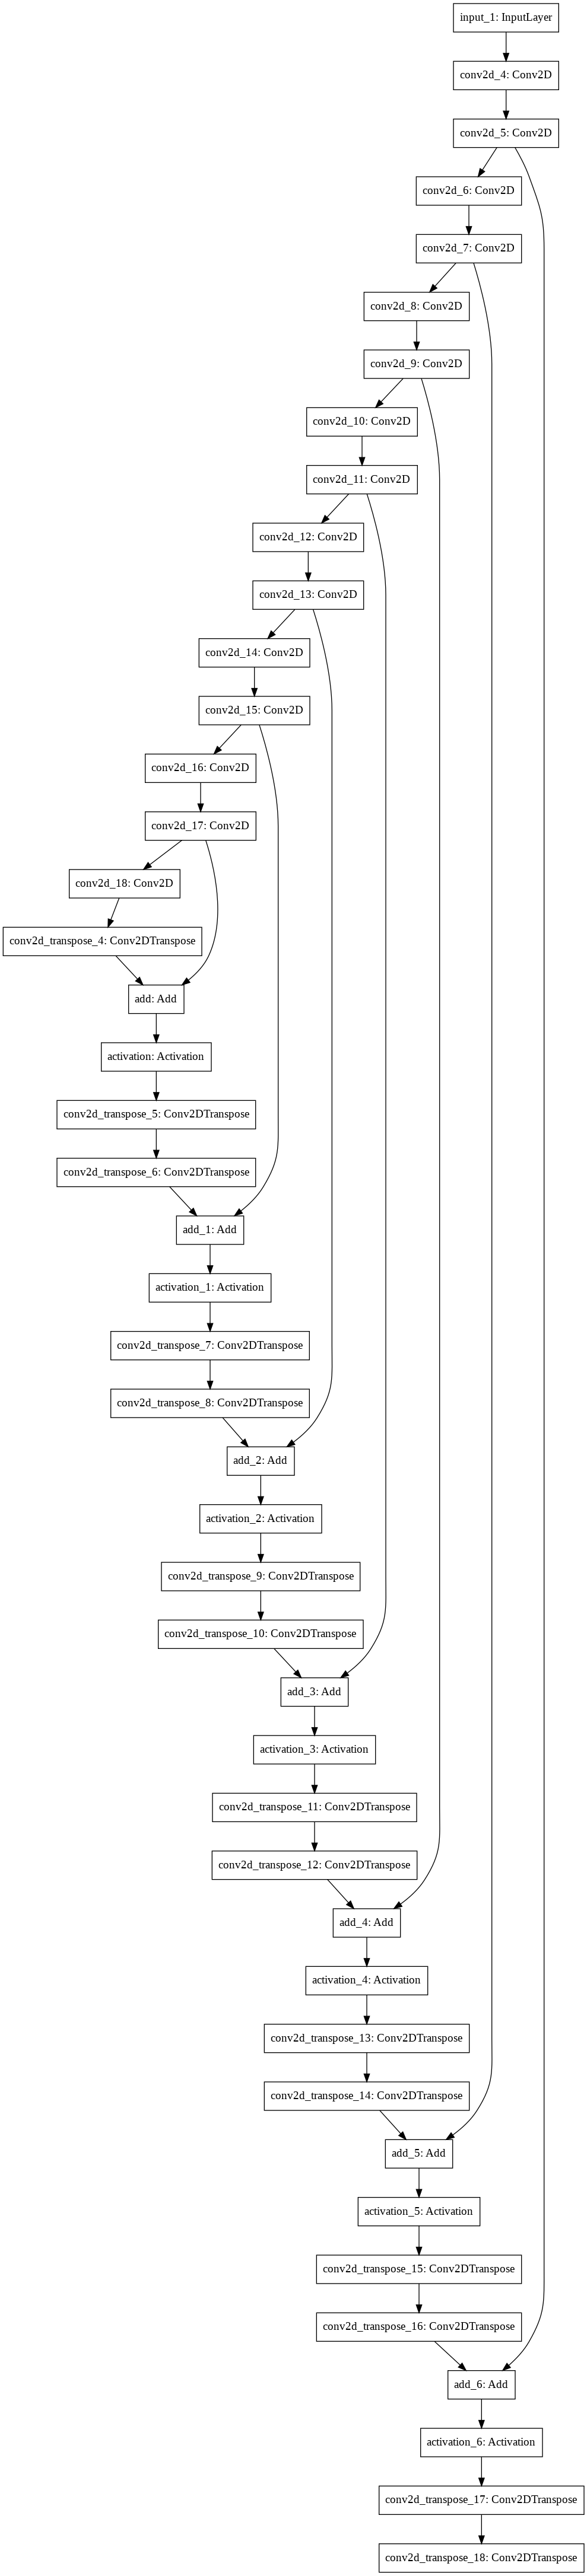

In [38]:
model = REDNet(15)
model.compile(optimizer=tf.optimizers.Adam(0.0001), loss='mse', metrics=[psnr_metric])
#네트워크 시각화
tf.keras.utils.plot_model(model)

REDNet 함수의 num_layers 인수로 15를 넣어서 REDNet-30 네트워크를 만든다.    
컴파일 할 때 optimizer에는 0.0001의 학습률을 지정한 Adam을 사용하고,   
loss는 원본과 구성된 이미지의 평균 제곱 오차인 mse를 계산한다.    
그리고 학습이 잘 되는지 알아보기 위한 측정값을 지정하는 metrics에는 앞서 준비한 psnr_metric 함수를 넣는다.

#####tf.keras.utils.plot_model(model) : 네트워크를 시각화하여 볼 수 있다.
    
이제 학습시켜보자.

####네트워크 학습

In [ ]:
history = model.fit_generator(train_dataset, 
                              epochs = 1000,
                              steps_per_epoch=len(train_path)//16,
                              validation_data=valid_dataset,
                              validation_steps=len(valid_path),
                              verbose=2)

`Dataset을 이용한 학습은 fit() 함수 대신 fit_generator() 함수를 사용`한다. 그리고 `Dataset에 repeat()함수를 사용했기 때문에 한 번의 에포크에 몇 개의 데이터를 학습시킬지를 지정하는 steps_per_epoch 인수를 설정`해야한다. 훈련 데이터의 경우 batch size가 16이기 때문에 steps_per_epoch는 len(train_path)//으로, 훈련 데이터의 크기를 batch size로 나눈다.

학습에는 train_dataset을 검증에는 valid_dataset을 사용하고 검증할 때는 검증 데이터를 모두 한 번씩 사용하도록 validation_steps=len(valid_path)로 지정한다. 1,000 에포크의 많은 양을 학습시키기 때문에 tf.keras에 있는 출력 제한에 걸리지 않도록 verbose=2로 설정해서 진행 상황 애니메이션은 생략하고 각 에포크 결과만 출력한다.

####학습 결과 확인

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['psnr_metric'], 'b-', label='psnr')
plt.plot(history.history['val_psnr_metric'], 'r--', label='val_psnr')
plt.xlabel('Epoch')
plt.legend()
plt.show()

훈련 데이터와 검증 데이터의 PSNR 모두 학습할수록 증가하는 경향을 보인다.   
학습된 네트워크가 실제 이미지를 어떻게 복원하는지 확인해보자.

####PSNR 점수 확인

In [ ]:
img = tf.io.read_file(test_path[0])
img = tf.image.decode_jpeg(img, channels=3)
hr = tf.image.convert_image_dtype(img, tf.float32)

lr = tf.image.resize(hr, [hr.shape[0]//2, hr.shape[1]//2])
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])
predict_hr = model.predict(np.expand_dims(lr, axis=0))

print(tf.image.psnr(np.squeeze(predict_hr, axis=0), hr, max_val=1.0))
print(tf.image.psnr(lr, hr, max_val=1.0))

#####np.squeeze()
: 1차원인 배열을 제거한다. ex) [[1], [2]] -> [1,2]


테스트 데이터 중 첫 번째 이미지를 불러와서 저해상도 버전을 만든 다음 네트워크에 통과시켜서 복원 이미지를 얻어냈다. PSNR 점수가 복원 전 후에 크게 달라지지 않은 것 같다. 이미지로 확인해보자.

####결과 이미지 확인

In [ ]:
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.imshow(hr)
plt.title('original - hr')

plt.subplot(1,3,2)
plt.imshow(lr)
plt.title('lr')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(predict_hr, axis=0))
plt.title('sr')

plt.show()

첫 번째가 원본이미지, 두 번째가 저해상도 이미지, 세 번째가 복원한 이미지이다.    
이 작업의 성능을 비교하기 위한 벤치마크 중 유명한 것으로 Set5라는 데이터세트가 있다. 이름이 뜻하는 것처럼 다섯 개의 이미지를 모아놓은 것이다. 써보자.

####Set5 이미지를 불러와 테스팅

In [ ]:
image_path = tf.keras.utils.get_file('butterfly.png', 'http://bit.ly/2oAOxgH')
img = tf.io.read_file(image_path)
img = tf.image.decode_jpeg(img, channels=3)
hr = tf.image.convert_image_dtype(img, tf.float32)

lr = tf.image.resize(hr, [hr.shape[0]//2, hr.shape[1]//2])
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])
predict_hr = model.predict(np.expand_dims(lr, axis=0))

print(tf.image.psnr(np.squeeze(predict_hr, axis=0), hr, max_val=1.0))
print(tf.image.psnr(lr, hr, max_val=1.0))

plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.imshow(hr)
plt.title('original - hr')

plt.subplot(1,3,2)
plt.imshow(lr)
plt.title('lr')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(predict_hr, axis=0))
plt.title('sr')

확실히 벤치마크 답게 PSNR 점수에서 성능 차이가 뚜렷하게 드러난다. 결과 이미지도 훨씬 잘보인다.    
이처럼 Set5의 데이터들은 BSD 데이터에 비해 PSNR 점수가 잘 나오는 편이다.    
좀더 어려운 과제로 확대 비율을 늘려보자 현재는 2배인데 4배로 늘려보자.    
이는 어려운 과제이기 때문에 네트워크의 성능을 높이기 위해 이미지 보강을 해보자.   
Dataset에서는 쉽게 이미지를 보강할 수 있다. 이미지에서 랜덤한 부분을 잘라서 고해상도와 저해상도 버전을 추출하던 함수 get_hr_and_lr()을 다음과 같이 바꾸면 된다.

####2배에서 4배율로 모델 업그레이드하기

In [ ]:
import random
def get_hr_and_lr_flip_s4(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  hr = tf.image.random_crop(img, [50, 50, 3])
  lr = tf.image.resize(hr, [12,12])
  lr = tf.image.resize(lr, [50, 50])

  if random.random() <0.25:
    hr = tf.image.flip_left_right(hr)
    lr = tf.image.flip_left_right(lr)
  if random.random() < 0.25:
    hr = tf.image.flip_up_down(hr)
    lr = tf.image.flip_up_down(lr)

  return lr, hr

확대 비율을 바꾼걸 제외하면 앞 함수와 같고 뒤에는 25%의 확률로 좌우 반전, 상하 반전을 시켜준다.    
결과적으로 훈련 데이터가 거의 4배 늘어나는 효과를 갖는다.    
이제 바뀐 데이터로 학습을 시켜보자.

####4배율 네트워크 학습

In [ ]:
train_dataset = tf.data.Dataset.list_files(train_path)
train_dataset = train_dataset.map(get_hr_and_lr_flip_s4)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

valid_dataset = tf.data.Dataset.list_files(valid_path)
valid_dataset = valid_dataset.map(get_hr_and_lr_flip_s4)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(1)

model = REDNet(15)
model.compile(optimizer=tf.optimizers.Adam(0.0001), loss='mse', metrics=[psnr_metric])

history = model.fit_generator(train_dataset, 
                              epochs = 4000,
                              steps_per_epoch=len(train_path)//16,
                              validation_data=valid_dataset,
                              validation_steps=len(valid_path),
                              verbose=2)

이미지 보강으로 데이터가 4배 늘어났기 때문에 epoch를 4000까지 늘렸다.    
학습 결과 훈련 데이터의 PSNR은 26~28, 검증데이터는 25정도가 나온다. Set5 이미지를 테스트 해보면 다음과 같다.

####결과 확인

In [ ]:
image_path = tf.keras.utils.get_file('butterfly.png', 'http://bit.ly/2oAOxgH')
img = tf.io.read_file(image_path)
img = tf.image.decode_jpeg(img, channels=3)
hr = tf.image.convert_image_dtype(img, tf.float32)

lr = tf.image.resize(hr, [hr.shape[0]//2, hr.shape[1]//2])
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])
predict_hr = model.predict(np.expand_dims(lr, axis=0))

print(tf.image.psnr(np.squeeze(predict_hr, axis=0), hr, max_val=1.0))
print(tf.image.psnr(lr, hr, max_val=1.0))

plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.imshow(hr)
plt.title('original - hr')

plt.subplot(1,3,2)
plt.imshow(lr)
plt.title('lr')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(predict_hr, axis=0))
plt.title('sr')

약 2점 정도 점수차이가 난다. 이미지로도 확인해보면 복원이 잘 됐음을 볼 수 있다.

####Set5 이미지 로드

In [ ]:
image_path = tf.keras.utils.get_file('/content/Set5.zip', 'http://bit.ly/2MEG4kr')
!unzip Set5.zip

이미지를 불러온 다음 각 이미지에 대해 저해상도와 복원 이미지의 PSNR을 점수를 평균내서 비교해보자

####Set5 이미지에 대한 PSNR 점수 평균 비교

In [ ]:
set5_image_root = pathlib.Path('/content/Set5')
set5_image_paths = list(set5_image_root.glob('*.*'))

sr_psnr = []
lr_psnr = []

for image_path in set5_image_paths:
  img = tf.io.read_file(str(image_path))
  img = tf.image.decode_jpeg(img, channels=3)
  hr = tf.image.convert_image_dtype(img, tf.float32)
  lr = tf.image.resize(hr, [hr.shape[0]//4, hr.shape[1]//4])
  lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])
  predict_hr = model.predict(np.expand_dims(lr, axis=0))

  sr_psnr.append(tf.image.psnr(np.squeeze(predict_hr, axis=0), hr, max_val=1.0).numpy())
  lr_psnr.append(tf.image.psnr(lr, hr, max_val=1.0).numpy())

print('sr:', sr_psnr)
print('sr mean:', np.mean(sr_psnr))
print()
print('lr:', lr_psnr)
print('lr mean:', np.mean(lr_psnr))

복원 이미지의 PSNR 점수가 저해상도 버전보다 전반적으로 높다. 충분히 학습시키면 더 좋은 PSNR 점수를 얻을 수 있을 것이다.

##9.5 이미지 분할

이미지에서 단순히 경계선을 추출하는 작업은 전통적인 알고리즘의 필터나 한 층의 컨볼루션 레이어로도 가능하지만 `의미 있는 부분을 추출하고 이미지의 의미있는 부분과 그렇지 않은 부분으로 분할`하기 위해서는 학습이 필요하다. 앞 절에 정의한 REDNet을 조금만 수정하면 이미지 분할(Segmentation)에 사용할 수 있다.

In [ ]:
Image('/content/drive/My Drive/DeepLearning/Start!_Tensorflow/images/rednet_4.png', width='600')

위 그림에 분할의 예가 나와있다. 이 연구에서는 이미지의 각 부분(픽셀)을 의미 있는 부분집합으로 분류한다. 이보다는 좀더 쉽게 이미지의 경계선과 내용, 그리고 외곽 이렇게 3가지로 분류하는 Oxford-IIIT Pet 데이터세트로 이미지 분할 문제를 학습해보자.    
텐서플로 데이터세트에서 제공하는 Dataset을 바로 불러오자. 이경우 한 줄로 미리 준비된 이미지와 라벨을 편리하게 사용할 수 있다.

###Oxford Pet Dataset 불러오기

In [ ]:
import tensorflow_datasets as tfds
builder = tfds.builder('oxford_iiit_pet:3.1.0')
info = builder.info
print(info)
# by setting register_checksums as True to pass the check
config = tfds.download.DownloadConfig(register_checksums = True)
builder.download_and_prepare(download_config=config)
dataset = builder.as_dataset()

텐서플로 데이터세트에서 가져오는 데이터는 실제 Dataset와 그 Dataset에 대한 정보를 포함하고 있는 info로 구성돼 있다. info를 출력하면 Dataset를 빠르게 파악할 수 있다.

In [ ]:
info

Dataset의 주요 정보를 구성하고 있는 부분은 features이다. 여기에는 image와 label, segmentation_mask가 보인다. label은 각 애완동물에 대한 클래스 정보를 담고 있지만 여기서는 애완동물의 라벨분류를 학습하는 것이 아니기 때문에 다루지 않는다. image는 마지막 차원이 3인 것으로 보아 컬러 이미지일 것이라고 추측하고 있고, segmentation_mask는 마지막 차원이 1로 구성된걸로 볼 때 흑백 이미지처럼 다룰수 있다고 추측할 수 있다.

if에 포함된 내용을 보면 데이터가 train과 test로 구분되어있음을 볼 수 있다.    
이것을 Dataset을 학습시킬때 반복횟수로 사용하기 위해 인수로 저장한다.

###학습 데이터, 테스트 데이터 분리

In [ ]:
train_data_len = info.splits['train'].num_examples
test_data_len = info.splits['test'].num_examples

다음으로 이미지를 로드하는 함수를 정의한다. Dataset을 호출했을 때 받아올 수 인수중 image와 segmentation_mask를 사용할 것이기 때문에 Dataset의 원소를 받아서 이 두 데이터를 반환하는 함수를 만든다.

In [ ]:
def load_image(datapoint):
  img = tf.image.resize(datapoint['image'], (128,128))
  mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  img = tf.cast(img, tf.float32)
  img = img / 255.0
  mask -= 1

  return img, mask

앞 절에서 다룬 get_hr_and_lr() 함수와 비슷한 모습이다. 각 이미지의 마스크는 동일한 크기인 가로x세로 128 픽셀로 크기를 변환한다. 크기가 다르면 tf.keras에서 학습이 되지 않기 때문에 크기를 변환하는 것이다.    
그 다음에 이미지를 tf.float32로 바꿔준 다음에 정규화를 거치고 마스크는 1을 빼준다 왜일까?    
이유를 알아보자. 일단 Dataset을 만드는 부분은 앞 절의 코드와 거의 비슷하다.

In [ ]:
import tensorflow as tf
train_dataset = dataset['train'].map(load_image)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

test_dataset = dataset['test'].map(load_image)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(1)

dataset라는 변수명으로 불러온 전체 Dataset에서 train, test라는 키 이름으로 각각 dataset을 얻를 수 있다. 그 다음에 앞에 정의한 load_image()함수로 이미지와 마스크를 변환하고, 데이터를 계속 학습시킬 수 있도록 repeat()함수를 적용하고 배치 사이즈를 적용한다.

###이미지 확인

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
for img, mask in train_dataset.take(1):
  plt.figure(figsize=(10,5))

  plt.subplot(1,2,1)
  plt.imshow(img[2])

  plt.subplot(1,2,2)
  plt.imshow(np.squeeze(mask[2], axis=2))
  plt.colorbar()

마스크의 데이터에는 중심, 외곽, 배경을 뜻하는 1, 3, 2의 숫자가 각 픽셀에 대해 저장되어있다. 이미지 분할 문제는 기본적으로 각 픽셀을 분류하는 문제이기 때문에 라벨이 0부터 시작할수 있게 0, 1, 2로 바꿔주는 것이다.    
이미지 분할 네트워크의 학습은 원본 이미지를 입력했을 때 마스크를 출력하게 한다. 이를 위해서는 앞 절에 사용했던 REDNet에서 마지막 레이어를 수정해야 한다.

###이미지 분할을 위한 REDNet 네트워크 정의

In [ ]:
def REDNet_segmentation(num_layers):
  conv_layers = []
  deconv_layers = []
  residual_layers = []

  inputs = tf.keras.layers.Input(shape=(None, None, 3))
  conv_layers.append(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='relu'))

  for i in range(num_layers-1):
    conv_layers.append(tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    deconv_layers.append(tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding='same', activation='relu'))

  deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='softmax'))

  x = conv_layers[0](inputs)

  for i in range(num_layers-1):
    x = conv_layers[i+1](x)
    if i % 2 == 0:
      residual_layers.append(x)

  for i in range(num_layers-1):
    if i % 2 == 1:
      x = tf.keras.layers.Add()([x, residual_layers.pop()])
      x = tf.keras.layers.Activation('relu')(x)
    x = deconv_layers[i](x)

  x = deconv_layers[-1](x)

  model = tf.keras.Model(inputs=inputs, outputs=x)
  return model

수정된 부분은 마지막 레이어의 활성화함수 인데 원래 활성화 함수가 없었기 때문에 linear 활성화함수로 입력값을 그대로 출력하던 것을 소프트맥스 활성화함수로 교체했다.    
분류 문제로 바뀌었기 때문에 네트워크를 컴파일 할때의 loss도 바꿔줘야  한다.

In [ ]:
model = REDNet_segmentation(15)
model.compile(optimizer=tf.optimizers.Adam(0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

분류를 위해 loss에 sparse_categorical_crossentropy를 사용했고, 분류의 정확도를 측정하기 위해 metrics에 accuracy를 넣었다.    
이제 학습해보자.

In [ ]:
history = model.fit(train_dataset,
                    epochs = 20,
                    steps_per_epoch=train_data_len//16,
                    validation_data=test_dataset,
                    validation_steps=test_data_len)

이미지 분할은 초해상도 이미지를 얻는 문제보다는 쉽기 때문에 에포크를 20으로 설정한다. 검증 데이터가 따로 없기 때문에 테스트 데이터를 사용한다. 학습 결과 훈련 데이터에 대해 81%, 테스트 데이터에 대해서도 81% 정도의 분류 정확도를 보인다.

###테스트 이미지 분할 확인

In [ ]:
plt.figure(figsize=(12,12))
for idx, (img, mask) in enumerate(test_dataset.take(3)):
  plt.subplot(3,3,idx*3+1)
  plt.imshow(img[0])

  plt.subplot(3,3,idx*3+2)
  plt.imshow(np.squeeze(mask[0], axis=2))

  predict = tf.argmax(model.predict(img), axis=-1)
  plt.subplot(3,3,idx*3+3)
  plt.imshow(np.squeeze(predict[0], axis=0))

가운데 라인이 정답 마스크이고, 가장 오른쪽 열이 예측된 마스크이다. 나름 잘 예측하는 것 같다.    
그런데 우리가 훈련시킨 REDNet은 컨볼루션 레이어와 디컨볼루션 레이어로만 구성되어있어서 입력 이미지 사이즈의 제한이 없다.    
리사이즈 이미지 대신 원본 이미지를 넣어보자

In [ ]:
plt.figure(figsize=(12,12))
for idx, datapoint in enumerate(dataset['test'].test(3)):
  img = datapoint['image']
  mask = datapoint['segmentation_mask']

  img = tf.cast(img, tf.float32)
  img = img / 255.0
  mask -= 1

  plt.subplot(3,3,idx*3+1)
  plt.imshow(img)

  plt.subplot(3,3,idx*3+2)
  plt.imshow(np.squeeze(mask, axis=2))

  predict = tf.argmax(model.predict(tf.expand_dims(img, axis=0)), axis=-1)
  plt.subplot(3,3,idx*3+3)
  plt.imshow(predict[0], axis=0)

원본 이미지를 넣었을 때 출력을 봤을 때 다른 점은 노란색 선이 얇아졌다는 것이다. 정답 이미지에 비해 오히려 세밀한 예측을 하고있다는 것을 확인할 수 있다. 이미지가 깨지는 부분은 리사이즈에 비해 많이 보이지만 네트워크 학습에서 훈련 데이터와 테스트 데이터에 대해 loss는 계속 감소하고 정확도는 계속 증가하고 있기 때문에 에포크를 늘리거나 이미지 보강등의 방법을 사용하면 더 좋은 결과를 얻을 수 있을 것이다.

##9.6 정리

이번 장에서는 컨볼루션 레이어와 디컨볼루션 레이어를 대칭적으로 쌓아 올려 만든 오토 인코더에 대해 구현해 봣다. 기본적인 형태의 오토인코더는 자기 자신을 재생성하는 특징이 있다. 저해상도로 초해상도 이미지를 얻고, 출력에 분할 이미지를 넣으면 이미지 분할 문제를 학습시킬 수 있다.    
또 오토인코더의 중심에서 잠재변수를 추출할 수 있다. 잠재변수는 정보를 압축하는 과정에서 데이터의 특징을 가장 잘 나타내도록 학습되기 때문에 이를 클러스터링에 사용해 고차원의 데이터를 저차원으로 시각화할 수 있다.